<a href="https://colab.research.google.com/github/nabiila-29/data-fellowship-5/blob/main/Nabiila_Machine_Learning_Study_Case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 Load data and Package

In [1]:
import pandas as pd

In [2]:
#read and check excel file
df_raw1= pd.read_excel('Online Retail.xlsx')

In [3]:
df_raw1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df_raw1.shape

(541909, 8)

# 1. Data Preprocessing

## Drop Duplicate Value 

In [5]:
#drop duplicate
df_raw1= df_raw1.drop_duplicates()
df_raw1.shape

(536641, 8)

## Check Missing Value 

In [6]:
#check missing value
df_raw1.isnull().sum(axis=0)  

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

In [7]:
#only show data with values
df_raw2 = df_raw1[pd.notnull(df_raw1['CustomerID'])]
df_raw2.shape

(401604, 8)

## Checking Negative Value

In [8]:
#validate negative values in every column
df_raw2.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


Since there is negative value, we will remove the negative value because quantity cannot be negative. The negative is come from return transaction.

In [9]:
#data with Quantity >0
df = df_raw2[(df_raw2['Quantity'] > 0)]
df.shape

(392732, 8)

## Check Data Type

In [10]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

The invoice date has datetime format. All data type has match

## Check Data Correlation

In [11]:
df.corr()

,Quantity,UnitPrice,CustomerID
Quantity,1.000000,-0.004577,-0.00621
UnitPrice,-0.004577,1.000000,-0.01079
CustomerID,-0.006210,-0.010790,1.00000


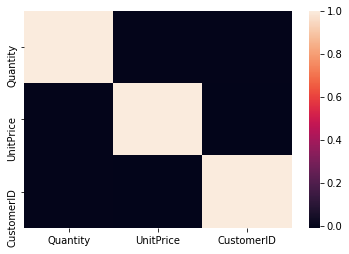

In [12]:
import seaborn as sns
sns.heatmap(df.corr())

Values closer to zero means there is no linear trend between the two variables. The close to 1 the correlation is the more positively correlated they are

The darker the color means there is weak correlation. There are many pdark colour ppppin the heatmap. It means the correlation between variable is weak. 

# 2. Feature Engineering

## Add New Column for Monetary

In [13]:
# add new column for monetary
df['TotalAmount']  = df['Quantity'] * df['UnitPrice']  
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## Create RFM Data Frame 

Recency, Frequencis, and Monetary

Recency= Latest Date - Last invoice date of every customer
Frequency = count of invoice number of transaction of every customer
Monetary = sum of total ammount of every customer

In [14]:
import datetime as dt

In [15]:
df['InvoiceDate'].sort_values(ascending=False)

541908   2011-12-09 12:50:00
541900   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541895   2011-12-09 12:50:00
541896   2011-12-09 12:50:00
                 ...        
4        2010-12-01 08:26:00
3        2010-12-01 08:26:00
2        2010-12-01 08:26:00
1        2010-12-01 08:26:00
0        2010-12-01 08:26:00
Name: InvoiceDate, Length: 392732, dtype: datetime64[ns]

To create the recency feature variable, we need to decide the reference date for our analysis. 

Usually, we make use of the last transaction date plus one day. Then, we will construct the recency variable as the number of days before the reference date when a customer last made a purchase.

so,the date is 2010-12-10

In [16]:
#determining latest date
latest_date = dt.datetime(2011,12,10)

In [17]:
#RFM modelling score for every customer
RFM_scores = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (latest_date - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalAmount': lambda x: x.sum()})

In [18]:
#convert invoice date to int to ease calculation
RFM_scores['InvoiceDate'] = RFM_scores['InvoiceDate'].astype(int)

In [19]:
#rename column and make dataframe of the RFM
RFM_scores.rename(columns={'InvoiceDate' : 'Recency',
                            'InvoiceNo': 'Frequency',
                            'TotalAmount' : 'Monetary'}, inplace =True)

In [20]:
RFM_scores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,310,17,334.40


# 3. Modelling

## Data Description

In [21]:
RFM_scores.describe()

,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000
mean,92.041484,90.512100,2048.215924
std,100.007757,225.515328,8984.248352
min,0.000000,1.000000,0.000000
25%,17.000000,17.000000,306.455000
50%,50.000000,41.000000,668.560000
75%,141.500000,98.000000,1660.315000
max,373.000000,7676.000000,280206.020000


### Recency 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


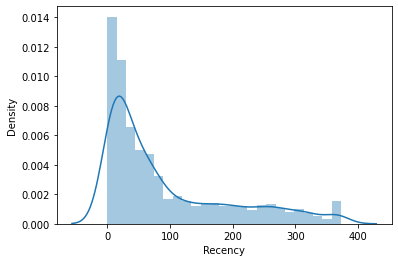

In [22]:
import seaborn as sns
x = RFM_scores['Recency']

sns.distplot(x)

### Frequency

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


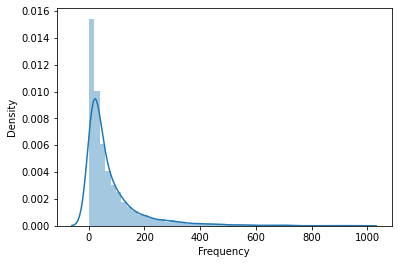

In [23]:
#only show less than 1000
y = RFM_scores.query('Frequency < 1000')['Frequency']

sns.distplot(y)

### Monetary

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


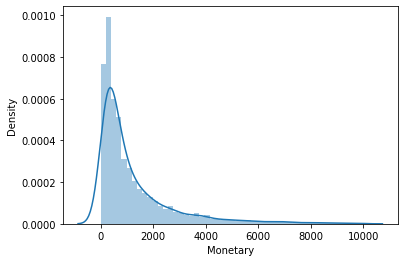

In [24]:
#only show less than 10000
z = RFM_scores.query('Monetary < 10000')['Monetary']

sns.distplot(z)

## Log Transformation for better distribution

In [25]:
#Handle negative and zero values so as to handle infinite numbers during log transformation
import numpy as np

def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
#Apply handle_neg_n_zero function to Recency and Monetary columns 
RFM_scores['Recency'] = [handle_neg_n_zero(x) for x in RFM_scores.Recency]
RFM_scores['Monetary'] = [handle_neg_n_zero(x) for x in RFM_scores.Monetary]

#Perform Log transformation to bring data into normal or near normal distribution
Log_Tfd_Data = RFM_scores[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

### Recency

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


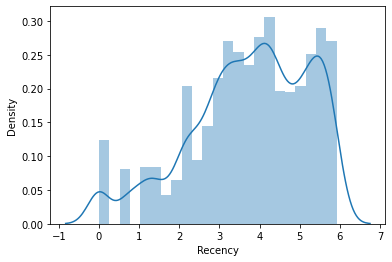

In [26]:
#Data distribution after data normalization for Recency
Recency_Plot = Log_Tfd_Data['Recency']
ax = sns.distplot(Recency_Plot)

### Frequency

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


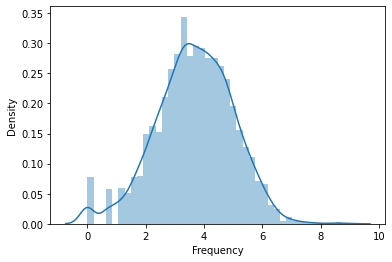

In [27]:
#Data distribution after data normalization for Frequency
Frequency_Plot = Log_Tfd_Data.query('Frequency < 1000')['Frequency']
ax = sns.distplot(Frequency_Plot)

### Monetary

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


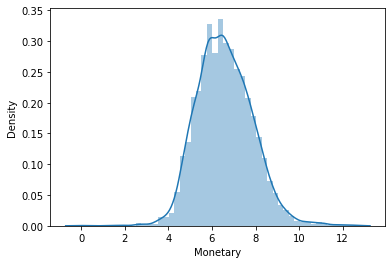

In [28]:
#Data distribution after data normalization for Monetary
Monetary_Plot = Log_Tfd_Data.query('Monetary < 10000')['Monetary']
ax = sns.distplot(Monetary_Plot)

## Machine Learning Algorithm

### Finding optimal number of cluster 

In [29]:
from sklearn.preprocessing import StandardScaler

#Bring the data on same scale
scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(Log_Tfd_Data)

#Transform it back to dataframe
Scaled_Data = pd.DataFrame(Scaled_Data, index = RFM_scores.index, columns = Log_Tfd_Data.columns)

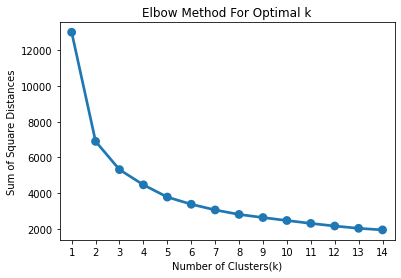

In [30]:
#show max of cluster
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### K-Means

In [31]:
#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(Scaled_Data)

#Find the clusters for the observation given in the dataset
RFM_scores['Cluster'] = KMean_clust.labels_                                  #new column
RFM_scores.head(10)

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,325,1,77183.60,1
12347.0,2,182,4310.00,0
12348.0,75,31,1797.24,1
12349.0,18,73,1757.55,1
12350.0,310,17,334.40,2
12352.0,36,85,2506.04,1
12353.0,204,4,89.00,2
12354.0,232,58,1079.40,1
12355.0,214,13,459.40,2


In [32]:
KMean_clust.cluster_centers_

array([[-1.26540739,  1.11832274,  1.19165622],
       [ 0.04968329,  0.25550905,  0.1732176 ],
       [ 0.69515368, -0.96370454, -0.91133446]])

First row is first cluster with label (Recency, Frequency, Monetary)
* Cluster with highest recency is cluster index 1
*  Cluster with highest frequency is cluster index 2
*  Cluster with highest monetary is cluster index 2

<Figure size 504x504 with 0 Axes>

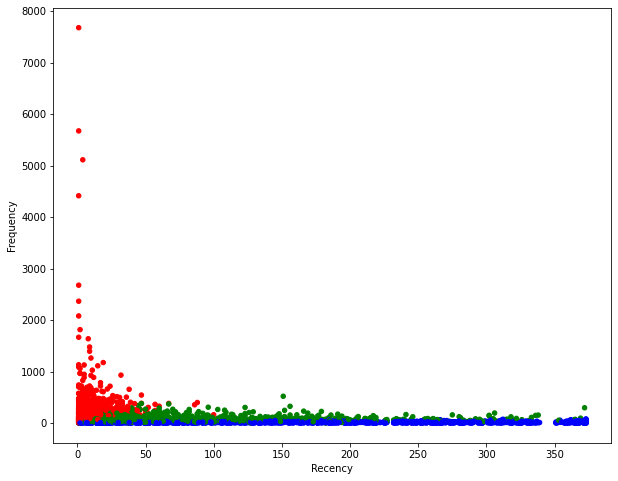

In [33]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Recency
Colors = ["red", "green", "blue"]
RFM_scores['Color'] = RFM_scores['Cluster'].map(lambda p: Colors[p])
ax = RFM_scores.plot(    
    kind="scatter", 
    x="Recency", y="Frequency",
    figsize=(10,8),
    c = RFM_scores['Color']
)

In [34]:
RFM_scores.head()

,Recency,Frequency,Monetary,Cluster,Color
CustomerID,,,,,
12346.0,325,1,77183.60,1,green
12347.0,2,182,4310.00,0,red
12348.0,75,31,1797.24,1,green
12349.0,18,73,1757.55,1,green
12350.0,310,17,334.40,2,blue


# 4. Evaluation

In [35]:
# 3 clusters
RFM_scores2 = RFM_scores.drop(['Color'], axis=1)

from sklearn.metrics import davies_bouldin_score
labels = KMean_clust.labels_
print(davies_bouldin_score(RFM_scores2, labels)) 

1.209850984726713


In [36]:
# trying 2 clusters
#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 2, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(Scaled_Data)

labels = KMean_clust.labels_
print(davies_bouldin_score(RFM_scores2, labels)) 

1.1588857105572


It will be better when the value of Davies Bouldin Score is greater. The 3 cluster is better than 2 cluster

---

